In [ ]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

In [ ]:
adata = sc.read("../../data/adata_pancreas_2019_endocrine.h5ad")
sc.pp.pca(adata, n_comps=30)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)
#sc.pl.umap(adata, color="celltype")

In [ ]:
(adata.obs["day"].values == np.sort(adata.obs["day"].values)).all()

In [ ]:
source_train = adata[adata.obs["day"]=="14.5"].obsm["X_pca"]
target_train = adata[adata.obs["day"]=="15.5"].obsm["X_pca"]


In [ ]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 1)


otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, cost_fn="graph", graph_kwargs={"k_neighbors": 512}, epsilon=1e-3, scale_cost="mean", input_dim=30, output_dim=30, iterations=10_000, k_noise_per_x=1)

In [ ]:
otfm.iterations=10
otfm(source_train, target_train, 1024, 1024)

In [ ]:
def compute_densities(source: jnp.ndarray, compute_densities_at: jnp.ndarray, rng: jax.Array, approx=True):

    def normal_log_likelihood(y):
        return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))

    def compute_p(target: jnp.ndarray, eps: jnp.ndarray):
        def approx_logp_wrapper(t, y, args):
            y, _ = y
            *args, eps, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            (eps_dfdy,) = vjp_fn(eps)
            logp = jnp.sum(eps_dfdy * eps)
            return f, logp

        def exact_logp_wrapper(t, y, args):
            y, _ = y
            y = jnp.atleast_2d(y)[0,:]
            *args, _, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            eye = jnp.eye(y.shape[-1])[:,None]
            (dfdy,) = jax.vmap(vjp_fn)(eye)
            logp = jnp.trace(dfdy)
            return f, logp
        
        fn_partial = partial(
                otfm.state_neural_net.apply_fn, {"params": otfm.state_neural_net.params}, condition=source,
            )
        
        term = diffrax.ODETerm(approx_logp_wrapper) if approx else diffrax.ODETerm(exact_logp_wrapper)
        t0=0.0
        t1=1.0
        dt0=0.00001
        eps = jnp.atleast_2d(eps)
        target = jnp.atleast_2d(target)
        x1_f1_stacked = (target, 0.0)
        solver = diffrax.Tsit5()
        #saveat = diffrax.SaveAt(ts=jnp.linspace(1, 0, 11
        saveat=None
        
        sol = diffrax.diffeqsolve(
            term, solver, t1, t0, -dt0, x1_f1_stacked, (eps, fn_partial), stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6)#, saveat=saveat
        )
        return sol.ys

    eps = jax.random.normal(rng, (1,))
    eps = jnp.ones_like(compute_densities_at) * eps
    compute_p_vmapped = jax.vmap(compute_p)
    out = compute_p_vmapped(compute_densities_at, eps)
    x_0 = jnp.squeeze(jnp.asarray(out[0]))
    f_0 = jnp.squeeze(jnp.asarray(out[1]))
    target_dim = compute_densities_at.shape[-1]
    logl = jax.scipy.stats.multivariate_normal.logpdf(x_0, np.zeros(target_dim), np.eye(target_dim))
    ps = jnp.exp(logl+f_0)
    return ps


In [ ]:
from functools import partial
import math
import diffrax
from tqdm import tqdm

In [ ]:
compute_densities_at = target_train
source_selected = source_train

In [ ]:
out = jax.vmap(partial(compute_densities, compute_densities_at=compute_densities_at, rng=jax.random.PRNGKey(0), approx=True))(source_selected)
    

In [9]:
out_len = len(source_train)
batch_size = 20

In [ ]:
compute_densities_at = target_train
source_selected = source_train

outputs = []
for batch in tqdm(range(0, out_len, batch_size)):
    out = jax.vmap(partial(compute_densities, compute_densities_at=compute_densities_at, rng=jax.random.PRNGKey(0), approx=True))(source_selected[batch:min(out_len, batch+batch_size),:])
    outputs.append(jax.device_put(out, device=jax.devices("cpu")[0]))
    
    

 82%|████████▏ | 182/221 [1:24:09<19:07, 29.42s/it]

In [129]:
outs_arr = np.asarray(outs)

In [130]:
outs_arr.shape

(103, 2780, 11)

In [131]:
outs_arr_fin = outs_arr[...,-1]

In [132]:
outs_arr_fin.shape

(103, 2780)

In [133]:
mass_ps = outs_arr_fin.sum(axis=1)

In [134]:
normalized_ps = outs_arr_fin / mass_ps[:,None]

In [135]:
normalized_ps.shape

(103, 2780)

In [136]:
normalized_ps.sum(axis=1)

array([0.9999999 , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 1.0000002 , 1.        ,
       0.99999976, 0.99999994, 0.99999994, 1.        , 1.        ,
       0.9999999 , 1.        , 0.99999994, 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999998 ,
       0.9999999 , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.0000001 ,
       1.0000002 , 1.0000001 , 0.99999994, 1.        , 1.0000001 ,
       0.99999994, 0.99999994, 1.        , 0.99999994, 1.        ,
       0.99999994, 1.0000001 , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 1.        , 0.99999994, 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.     

In [137]:
cond_density_integrated = normalized_ps.sum(axis=0)

In [141]:
normalized_ps.shape

(103, 2780)

In [138]:
cond_density_integrated.shape

(2780,)

In [139]:
source_train.shape, target_train.shape

((4417, 30), (2780, 30))

In [140]:
(adata.obs["day"].values == np.sort(adata.obs["day"].values)).all()

True

In [146]:
arr = np.concatenate((np.zeros(len(source_train),), cond_density_integrated), axis=0)

In [148]:
adata.obs["cond_density_fev_alpha"] = arr

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


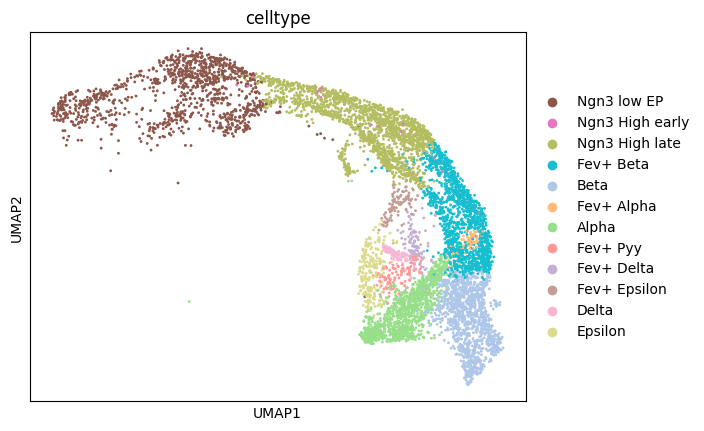

In [153]:
sc.pl.umap(adata, color="celltype")

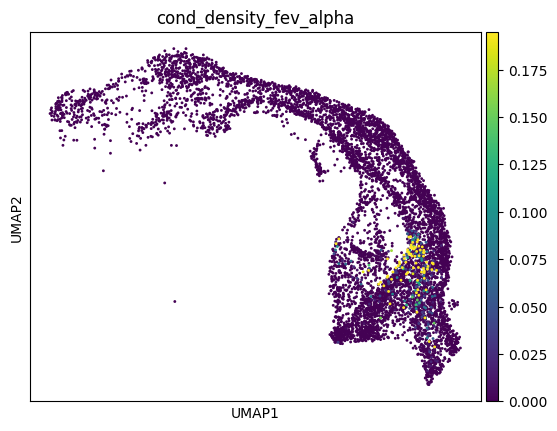

In [150]:
sc.pl.umap(adata, color="cond_density_fev_alpha", vmax="p99")


In [18]:
adata.obs["is_fev_alpha"] = (adata.obs["celltype"]=="Fev+ Alpha") * 1.0

In [21]:
adata.obs["day"].value_counts()

day
14.5    4417
15.5    2780
Name: count, dtype: int64

In [23]:
adata[adata.obs["is_fev_alpha"]==True]

View of AnnData object with n_obs × n_vars = 109 × 16206
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype', 'is_fev_alpha'
    var: 'n_cells', 'highly_variable_genes', 'expression_mean', 'dispersion'
    uns: 'celltype_colors', 'clusters_fig6_fine_final_colors', 'day_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

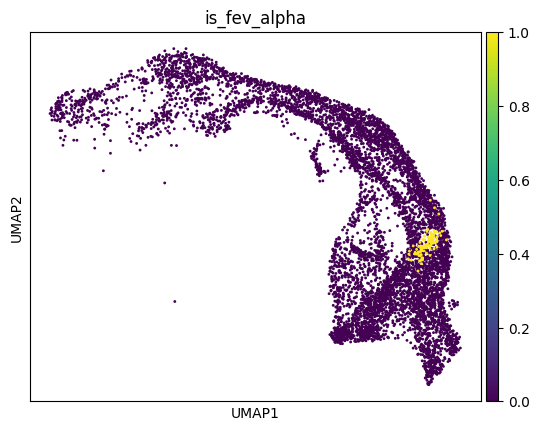

In [20]:
sc.pl.umap(adata, color="is_fev_alpha")

# Downstream analysis

In [170]:
push_source = [None] * 30

for i in range(30):
    push_source[i] = otfm.transport(source_train, seed=i)[0][0,...]

In [171]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [172]:
cosine_vars_source = compute_directional_statistics_from_samples(np.array(push_source), 2, adata[adata.obs["day"]=="14.5"].obs_names)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 4414 out of 4417 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 4417 out of 4417 | elapsed:    9.4s finished


In [173]:
adata.obs["directional_cosine_sim_variance"] = cosine_vars_source[0]["directional_cosine_sim_variance"]

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


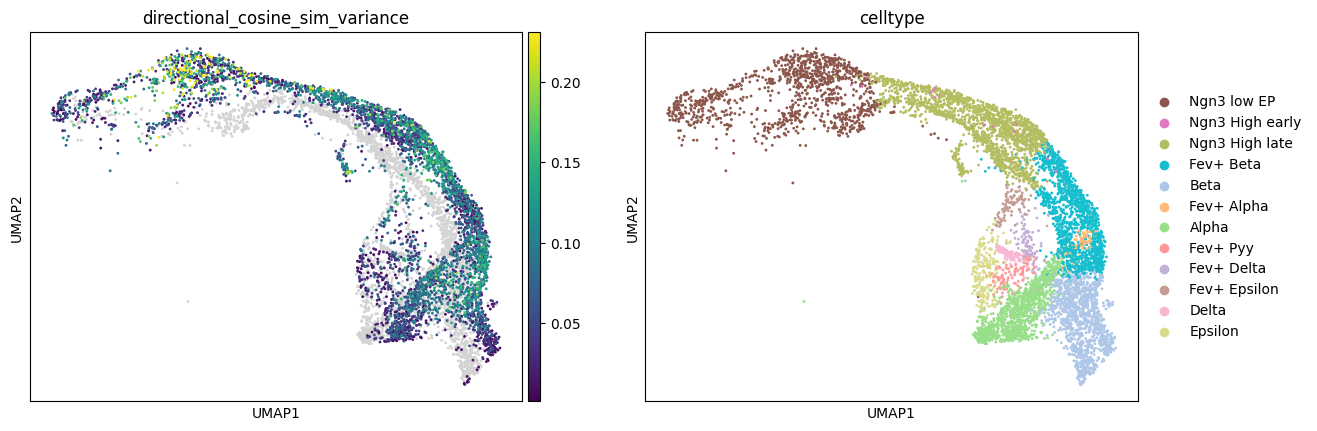

In [178]:
sc.pl.umap(adata, color=["directional_cosine_sim_variance", "celltype"], vmax="p99", )

In [175]:
cell_types = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+ Epsilon", "Fev+ Pyy", "Alpha", "Beta", "Delta", "Epsilon"]
adata.obs["cell_type_ordered"] = pd.Categorical(adata.obs.celltype, categories=cell_types, ordered=True)

Text(0.5, 0, 'Cell type')

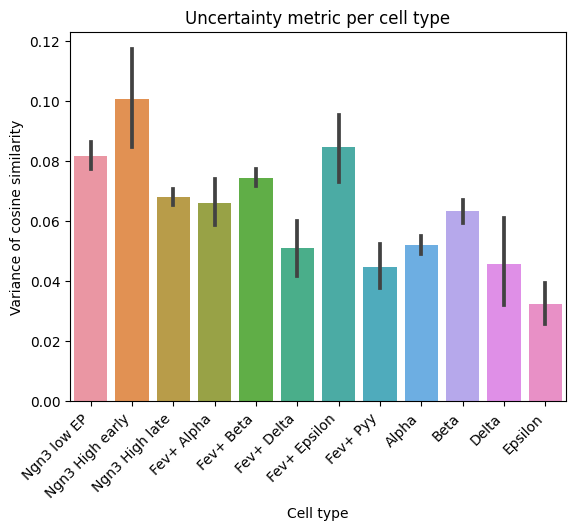

In [176]:
import seaborn as sns
g = sns.barplot(adata.obs, x="cell_type_ordered", y="directional_cosine_sim_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Uncertainty metric per cell type")
g.set_ylabel("Variance of cosine similarity")
g.set_xlabel("Cell type")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


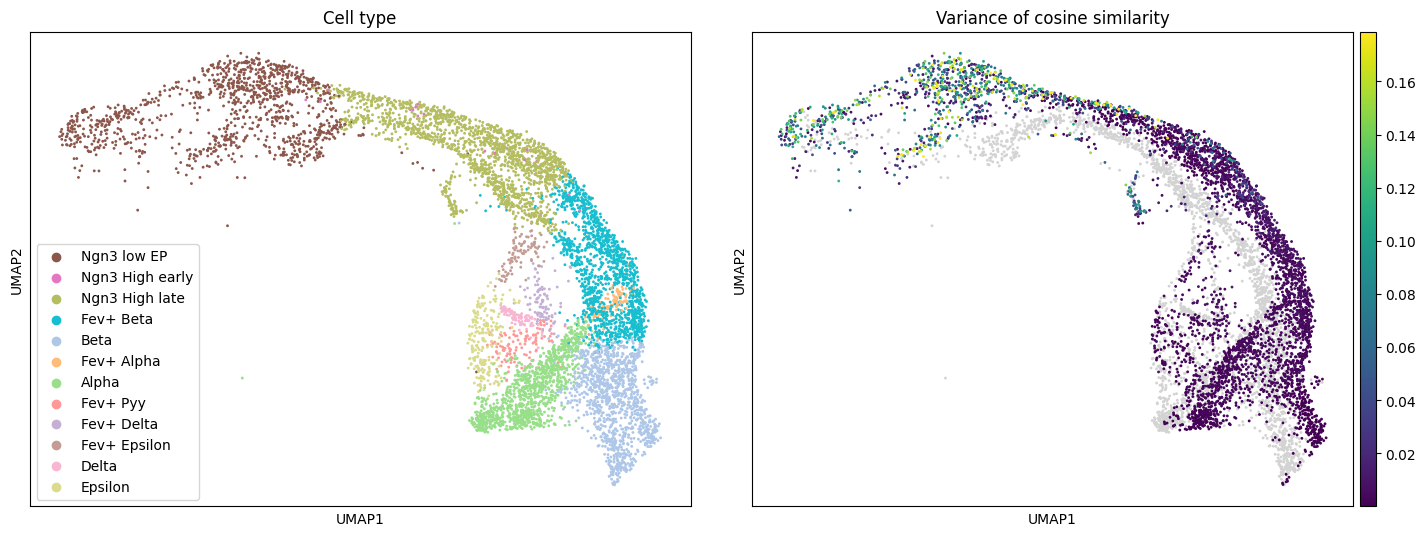

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["celltype"], vmax="p99", show=False, ax=ax1)
sc.pl.umap(adata, color=["directional_cosine_sim_variance"], vmax="p99", show=False, ax=ax2)
ax1.legend()
ax1.set_title("Cell type")
ax2.set_title("Variance of cosine similarity")
plt.tight_layout(pad=3.0)
plt.show()

In [179]:
adata.write("pancreas_downstream_results_new.h5ad")